# Importação e preparação dos dados

In [1]:
import pandas as pd

df = pd.read_csv('jurisprudencia_selecionada_enunciados.txt', sep = '|')
df.head()

,COD,NUM_ENUNCIADO,COD_AREA,DESCR_AREA,COD_TEMA,DESCR_TEMA,COD_SUBTEMA,DESCR_SUBTEMA,COD_DOC_TRAMITAVEL_ENUNCIADO,TEXTO_ENUNCIADO,ACORDAO,TIPO_PROCESSO
0,1400,1236,50,Responsabilidade,488,Solidariedade,261,Benefício previdenciário,54995437,Não comprovada a participação do beneficiário ...,Acórdão 297/2016 - PL,Tomada de Contas Especial
1,1700,1534,46,Finanças Públicas,981,Exportação,983,Petróleo,55025587,A operação ficta de exportação de plataformas ...,Acórdão 366/2016 - PL,Solicitação do Congresso Nacional
2,5700,5314,50,Responsabilidade,203,Multa,1021,Dosimetria,55455370,"No âmbito do TCU, a dosimetria da pena tem com...",Acórdão 944/2016 - PL,Acompanhamento
3,284,40,45,Direito Processual,162,Princípio da independência das instâncias,481,Decisão judicial,54773746,O princípio da independência das instâncias pe...,Acórdão 30/2016 - PL,Tomada de Contas Especial
4,298,54,49,Pessoal,141,Sistema S,142,Nepotismo,54773402,É vedado aos dirigentes das entidades do Siste...,Acórdão 55/2016 - PL,Representação


In [2]:
df.shape

(13312, 12)

In [3]:
df.groupby(['DESCR_AREA']).size()

DESCR_AREA
Competência do TCU          557
Contrato Administrativo     942
Convênio                    685
Desestatização              140
Direito Processual         1813
Finanças Públicas           328
Gestão Administrativa       339
Licitação                  2765
Pessoal                    3396
Responsabilidade           2347
dtype: int64

In [4]:
areas = df.groupby(['DESCR_AREA']).groups.keys()
areas

dict_keys(['Competência do TCU', 'Contrato Administrativo', 'Convênio', 'Desestatização', 'Direito Processual', 'Finanças Públicas', 'Gestão Administrativa', 'Licitação', 'Pessoal', 'Responsabilidade'])

In [5]:
from sklearn.preprocessing import LabelBinarizer

lbArea = LabelBinarizer()
lbArea.fit([x for x in areas])
lbArea.classes_

array(['Competência do TCU', 'Contrato Administrativo', 'Convênio',
       'Desestatização', 'Direito Processual', 'Finanças Públicas',
       'Gestão Administrativa', 'Licitação', 'Pessoal',
       'Responsabilidade'], dtype='<U23')

In [6]:
y = lbArea.transform(df['DESCR_AREA'])
y.shape

(13312, 10)

In [7]:
from keras.preprocessing.text import Tokenizer
import numpy as np

vocabulario = 20000
limite_texto = 200
dim_vetor = 100

tokenizer = Tokenizer(num_words=vocabulario)
tokenizer.fit_on_texts(df['TEXTO_ENUNCIADO'])

sequences = tokenizer.texts_to_sequences(df['TEXTO_ENUNCIADO'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 15387 unique tokens.


In [8]:
max = 0
lens = []
for seq in sequences:
    lens.append(len(seq))
np.min(lens), np.mean(lens), np.max(lens), np.std(lens), len(lens), sum(pd.Series(lens) > 200)

(6, 45.17240084134615, 633, 22.57216215856166, 13312, 15)

In [9]:
from keras.preprocessing.sequence import pad_sequences

x = pad_sequences(sequences, maxlen=limite_texto)

print('Shape of data tensor:', x.shape)

Shape of data tensor: (13312, 200)


In [10]:
x.shape, y.shape

((13312, 200), (13312, 10))

# Treinamento

In [11]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Embedding

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(SimpleRNN(256))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta',  metrics=["categorical_accuracy"])
model.summary()

W0811 22:21:24.370933 140625392871232 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 22:21:24.382889 140625392871232 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 22:21:24.385090 140625392871232 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 22:21:24.524893 140625392871232 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          2000000   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 256)               91392     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 2,093,962
Trainable params: 2,093,962
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

W0811 22:21:29.363127 140625392871232 deprecation.py:323] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0811 22:21:29.522457 140625392871232 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 10649 samples, validate on 2663 samples
Epoch 1/20
10649/10649 [==============================] - 25s 2ms/step - loss: 2.0226 - categorical_accuracy: 0.2641 - val_loss: 2.1966 - val_categorical_accuracy: 0.1889
Epoch 2/20
10649/10649 [==============================] - 23s 2ms/step - loss: 1.8140 - categorical_accuracy: 0.3844 - val_loss: 1.8714 - val_categorical_accuracy: 0.3090
Epoch 3/20
10649/10649 [==============================] - 23s 2ms/step - loss: 1.6826 - categorical_accuracy: 0.4464 - val_loss: 2.0279 - val_categorical_accuracy: 0.2786
Epoch 4/20
10649/10649 [==============================] - 24s 2ms/step - loss: 1.6313 - categorical_accuracy: 0.4707 - val_loss: 1.7418 - val_categorical_accuracy: 0.4484
Epoch 5/20
10649/10649 [==============================] - 23s 2ms/step - loss: 1.3032 - categorical_accuracy: 0.5822 - val_loss: 1.4745 - val_categorical_accuracy: 0.5325
Epoch 6/20
10649/10649 [==============================] - 24s 2ms/step - loss: 1.0774 - categori

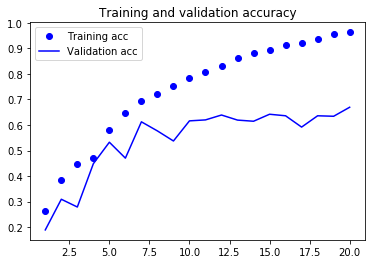

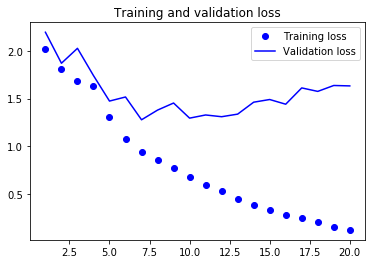

In [14]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
from keras.layers import GRU

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(GRU(256))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=["categorical_accuracy"])
model.summary()

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 100)          2000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               274176    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 2,276,746
Trainable params: 2,276,746
Non-trainable params: 0
_________________________________________________________________
Train on 10649 samples, validate on 2663 samples
Epoch 1/20
10649/10649 [==============================] - 57s 5ms/step - loss: 1.3817 - categorical_accuracy: 0.5309 - val_loss: 1.0729 - val_categorical_accuracy: 0.6650
Epoch 2/20
10649/10649 [==============================] - 56s 5ms/step - loss: 0.5755 - categorical_accuracy: 0.8183 - val_loss: 0.7486 - val_categorical_accuracy: 0.7792
Epoch

In [18]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(LSTM(256))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=["categorical_accuracy"])
model.summary()

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 100)          2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 2,368,138
Trainable params: 2,368,138
Non-trainable params: 0
_________________________________________________________________
Train on 10649 samples, validate on 2663 samples
Epoch 1/20
10649/10649 [==============================] - 70s 7ms/step - loss: 1.4046 - categorical_accuracy: 0.5244 - val_loss: 1.0654 - val_categorical_accuracy: 0.6579
Epoch 2/20
10649/10649 [==============================] - 69s 7ms/step - loss: 0.6492 - categorical_accuracy: 0.7884 - val_loss: 0.8428 - val_categorical_accuracy: 0.7349
Epoch

In [19]:
from keras.layers import Bidirectional

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Bidirectional(SimpleRNN(256)))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=["categorical_accuracy"])
model.summary()

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 100)          2000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               182784    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 2,187,914
Trainable params: 2,187,914
Non-trainable params: 0
_________________________________________________________________
Train on 10649 samples, validate on 2663 samples
Epoch 1/20
10649/10649 [==============================] - 37s 3ms/step - loss: 1.9635 - categorical_accuracy: 0.3052 - val_loss: 1.9216 - val_categorical_accuracy: 0.2186
Epoch 2/20
10649/10649 [==============================] - 37s 3ms/step - loss: 1.6218 - categorical_accuracy: 0.4861 - val_loss: 1.7495 - val_categorical_accuracy: 0.4424
Epoch

In [20]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Bidirectional(GRU(256)))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=["categorical_accuracy"])
model.summary()

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 100)          2000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               548352    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 2,553,482
Trainable params: 2,553,482
Non-trainable params: 0
_________________________________________________________________
Train on 10649 samples, validate on 2663 samples
Epoch 1/20
10649/10649 [==============================] - 100s 9ms/step - loss: 1.4726 - categorical_accuracy: 0.4970 - val_loss: 1.3131 - val_categorical_accuracy: 0.5712
Epoch 2/20
10649/10649 [==============================] - 99s 9ms/step - loss: 0.7837 - categorical_accuracy: 0.7291 - val_loss: 0.8875 - val_categorical_accuracy: 0.7217
Epoc

In [21]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Bidirectional(LSTM(256)))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=["categorical_accuracy"])
model.summary()

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 200, 100)          2000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 512)               731136    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5130      
Total params: 2,736,266
Trainable params: 2,736,266
Non-trainable params: 0
_________________________________________________________________
Train on 10649 samples, validate on 2663 samples
Epoch 1/20
10649/10649 [==============================] - 126s 12ms/step - loss: 1.3166 - categorical_accuracy: 0.5374 - val_loss: 1.0455 - val_categorical_accuracy: 0.6853
Epoch 2/20
10649/10649 [==============================] - 124s 12ms/step - loss: 0.7376 - categorical_accuracy: 0.7542 - val_loss: 0.8998 - val_categorical_accuracy: 0.7473
E

In [22]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(GRU(128))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=["categorical_accuracy"])
model.summary()

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 200, 100)          2000000   
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               87936     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 2,089,226
Trainable params: 2,089,226
Non-trainable params: 0
_________________________________________________________________
Train on 10649 samples, validate on 2663 samples
Epoch 1/20
10649/10649 [==============================] - 57s 5ms/step - loss: 1.4039 - categorical_accuracy: 0.5244 - val_loss: 1.0735 - val_categorical_accuracy: 0.6286
Epoch 2/20
10649/10649 [==============================] - 56s 5ms/step - loss: 0.6603 - categorical_accuracy: 0.7822 - val_loss: 0.7896 - val_categorical_accuracy: 0.7702
Epoch

In [23]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(GRU(64))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=["categorical_accuracy"])
model.summary()

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 200, 100)          2000000   
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                31680     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                650       
Total params: 2,032,330
Trainable params: 2,032,330
Non-trainable params: 0
_________________________________________________________________
Train on 10649 samples, validate on 2663 samples
Epoch 1/20
10649/10649 [==============================] - 57s 5ms/step - loss: 1.4666 - categorical_accuracy: 0.5002 - val_loss: 1.2265 - val_categorical_accuracy: 0.5959
Epoch 2/20
10649/10649 [==============================] - 56s 5ms/step - loss: 0.6659 - categorical_accuracy: 0.7835 - val_loss: 0.8770 - val_categorical_accuracy: 0.7567
Epoch

In [24]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(GRU(512))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=["categorical_accuracy"])
model.summary()

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 200, 100)          2000000   
_________________________________________________________________
gru_5 (GRU)                  (None, 512)               941568    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                5130      
Total params: 2,946,698
Trainable params: 2,946,698
Non-trainable params: 0
_________________________________________________________________
Train on 10649 samples, validate on 2663 samples
Epoch 1/20
10649/10649 [==============================] - 57s 5ms/step - loss: 1.4041 - categorical_accuracy: 0.5319 - val_loss: 1.1134 - val_categorical_accuracy: 0.6192
Epoch 2/20
10649/10649 [==============================] - 56s 5ms/step - loss: 0.5892 - categorical_accuracy: 0.8113 - val_loss: 0.7049 - val_categorical_accuracy: 0.7923
Epoch

In [25]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(GRU(256))
model.add(Dense(128, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=["categorical_accuracy"])
model.summary()

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 200, 100)          2000000   
_________________________________________________________________
gru_6 (GRU)                  (None, 256)               274176    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1290      
Total params: 2,308,362
Trainable params: 2,308,362
Non-trainable params: 0
_________________________________________________________________
Train on 10649 samples, validate on 2663 samples
Epoch 1/20
10649/10649 [==============================] - 57s 5ms/step - loss: 1.3405 - categorical_accuracy: 0.5431 - val_loss: 1.1215 - val_categorical_accuracy: 0.6485
Epoch 2/20
10649/10649 [====================

In [26]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(GRU(256))
model.add(Dense(64, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=["categorical_accuracy"])
model.summary()

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 200, 100)          2000000   
_________________________________________________________________
gru_7 (GRU)                  (None, 256)               274176    
_________________________________________________________________
dense_12 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_13 (Dense)             (None, 10)                650       
Total params: 2,291,274
Trainable params: 2,291,274
Non-trainable params: 0
_________________________________________________________________
Train on 10649 samples, validate on 2663 samples
Epoch 1/20
10649/10649 [==============================] - 57s 5ms/step - loss: 1.4478 - categorical_accuracy: 0.5017 - val_loss: 1.2458 - val_categorical_accuracy: 0.5896
Epoch 2/20
10649/10649 [====================

In [27]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(GRU(256))
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=["categorical_accuracy"])
model.summary()

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 200, 100)          2000000   
_________________________________________________________________
gru_8 (GRU)                  (None, 256)               274176    
_________________________________________________________________
dense_14 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_15 (Dense)             (None, 10)                330       
Total params: 2,282,730
Trainable params: 2,282,730
Non-trainable params: 0
_________________________________________________________________
Train on 10649 samples, validate on 2663 samples
Epoch 1/20
10649/10649 [==============================] - 59s 6ms/step - loss: 1.4137 - categorical_accuracy: 0.5170 - val_loss: 1.0261 - val_categorical_accuracy: 0.6658
Epoch 2/20
10649/10649 [====================

In [28]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(GRU(256, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=["categorical_accuracy"])
model.summary()

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

W0812 02:32:38.886567 140625392871232 deprecation.py:506] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 200, 100)          2000000   
_________________________________________________________________
gru_9 (GRU)                  (None, 256)               274176    
_________________________________________________________________
dense_16 (Dense)             (None, 10)                2570      
Total params: 2,276,746
Trainable params: 2,276,746
Non-trainable params: 0
_________________________________________________________________
Train on 10649 samples, validate on 2663 samples
Epoch 1/20
10649/10649 [==============================] - 67s 6ms/step - loss: 1.4181 - categorical_accuracy: 0.5189 - val_loss: 1.0890 - val_categorical_accuracy: 0.6463
Epoch 2/20
10649/10649 [==============================] - 65s 6ms/step - loss: 0.6399 - categorical_accuracy: 0.7962 - val_loss: 0.8191 - val_categorical_accuracy: 0.7646
Epoch

In [30]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(GRU(256, dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=["categorical_accuracy"])
model.summary()

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 200, 100)          2000000   
_________________________________________________________________
gru_10 (GRU)                 (None, 256)               274176    
_________________________________________________________________
dense_17 (Dense)             (None, 10)                2570      
Total params: 2,276,746
Trainable params: 2,276,746
Non-trainable params: 0
_________________________________________________________________
Train on 10649 samples, validate on 2663 samples
Epoch 1/20
10649/10649 [==============================] - 67s 6ms/step - loss: 1.4751 - categorical_accuracy: 0.5074 - val_loss: 1.1594 - val_categorical_accuracy: 0.6395
Epoch 2/20
10649/10649 [==============================] - 65s 6ms/step - loss: 0.7497 - categorical_accuracy: 0.7595 - val_loss: 0.8329 - val_categorical_accuracy: 0.7477
Epoch

In [31]:
from keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(GRU(256))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),  metrics=["categorical_accuracy"])
model.summary()

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 200, 100)          2000000   
_________________________________________________________________
gru_11 (GRU)                 (None, 256)               274176    
_________________________________________________________________
dense_18 (Dense)             (None, 10)                2570      
Total params: 2,276,746
Trainable params: 2,276,746
Non-trainable params: 0
_________________________________________________________________
Train on 10649 samples, validate on 2663 samples
Epoch 1/20
10649/10649 [==============================] - 59s 5ms/step - loss: 1.4352 - categorical_accuracy: 0.5175 - val_loss: 1.2630 - val_categorical_accuracy: 0.6324
Epoch 2/20
10649/10649 [==============================] - 56s 5ms/step - loss: 0.7153 - categorical_accuracy: 0.7670 - val_loss: 0.7977 - val_categorical_accuracy: 0.7552
Epoch

In [32]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(GRU(256))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta',  metrics=["categorical_accuracy"])
model.summary()

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 200, 100)          2000000   
_________________________________________________________________
gru_12 (GRU)                 (None, 256)               274176    
_________________________________________________________________
dense_19 (Dense)             (None, 10)                2570      
Total params: 2,276,746
Trainable params: 2,276,746
Non-trainable params: 0
_________________________________________________________________
Train on 10649 samples, validate on 2663 samples
Epoch 1/20
10649/10649 [==============================] - 58s 5ms/step - loss: 1.7543 - categorical_accuracy: 0.3958 - val_loss: 1.5719 - val_categorical_accuracy: 0.5103
Epoch 2/20
10649/10649 [==============================] - 56s 5ms/step - loss: 1.0487 - categorical_accuracy: 0.6483 - val_loss: 1.0767 - val_categorical_accuracy: 0.6474
Epoch

In [38]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(GRU(256, return_sequences=True))
model.add(GRU(32))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=["categorical_accuracy"])
model.summary()

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 200, 100)          2000000   
_________________________________________________________________
gru_19 (GRU)                 (None, 200, 256)          274176    
_________________________________________________________________
gru_20 (GRU)                 (None, 32)                27744     
_________________________________________________________________
dense_21 (Dense)             (None, 10)                330       
Total params: 2,302,250
Trainable params: 2,302,250
Non-trainable params: 0
_________________________________________________________________
Train on 10649 samples, validate on 2663 samples
Epoch 1/20
10649/10649 [==============================] - 113s 11ms/step - loss: 1.3182 - categorical_accuracy: 0.5488 - val_loss: 0.9676 - val_categorical_accuracy: 0.7041
Epoch 2/20
10649/10649 [==================

In [41]:
from keras.layers.core import Dropout

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(GRU(256, dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=["categorical_accuracy"])
model.summary()

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 200, 100)          2000000   
_________________________________________________________________
gru_23 (GRU)                 (None, 256)               274176    
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 10)                1290      
Total params: 2,308,362
Trainable params: 2,308,362
Non-trainable params: 0
_________________________________________________________________
Train on 10649 samples, validate on 2663 samples
Epoch 1/20
10649/10649 [==============================] - 68s 6ms/step - loss: 1.51

In [42]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(GRU(256))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=["categorical_accuracy"])
model.summary()

history = model.fit(x, y, epochs=20, batch_size=64, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 200, 100)          2000000   
_________________________________________________________________
gru_24 (GRU)                 (None, 256)               274176    
_________________________________________________________________
dense_25 (Dense)             (None, 10)                2570      
Total params: 2,276,746
Trainable params: 2,276,746
Non-trainable params: 0
_________________________________________________________________
Train on 10649 samples, validate on 2663 samples
Epoch 1/20
10649/10649 [==============================] - 31s 3ms/step - loss: 1.7200 - categorical_accuracy: 0.4266 - val_loss: 1.5657 - val_categorical_accuracy: 0.4949
Epoch 2/20
10649/10649 [==============================] - 29s 3ms/step - loss: 0.8242 - categorical_accuracy: 0.7287 - val_loss: 0.9061 - val_categorical_accuracy: 0.7105
Epoch